# 过拟合与欠拟合
本篇讨论一个机器学习中最基本的理论，过拟合与欠拟合，力图用最直白的语言来阐述。    
`` Tips: 深度学习是机器学习的子集，机器学习又是人工智能化的子集。    
本篇会重点讨论什么是过拟合和欠拟合，具体表现，解决方法，以及结合多项式拟合给出具体的实验结果。

## 1. 训练集、测试集、验证集
任何一个机器学习任务，我们都需要收集许多样本，比如在企业中经常要处理的CTR预估模型，用户没有点击过的是负样本，用户点击过的是正样本（不过实际中常常用随机的方法选择正样本），然后我们学习得到我们的模型，但是模型一定是应用到我们没有见过的样本上面的，这些样本就是测试集。实际中在机器学习过程中不可能看到测试样本，所以我们常常通过一种方法来模拟出测试样本，也就是验证集。通常，我们将样本分成N分，拿其中N-1份当做训练集，剩余一份当做测试集，然后求N份分别当测试集的效果的平均值，来模拟我们在真实情况下的误差。这种方法称为N择交叉验证法。最后将模型应用的线上，观测实际效果。

注意：后文说的测试集都是验证测试集合，是从训练样本中取出一部分的集合，欠拟合和过拟合都指的是训练集和验证测试集上的表现。如果验证集表现不错，但实际线上效果很差，这个很有可能是样本构造或者特征处理没有对齐，后面专门讲解如何处理此类情况。

## 2. 过拟合和欠拟合通俗理解
### 2.1 过拟合
+ 具体表现：模型在训练集的误差远远好过在测试集上的表现
+ 解决方法：常见的方法有，正则化、DropOut、增加训练样本、选择复杂度更低的模型、提前终止学习

### 2.2 欠拟合
+ 具体表现：模型在训练集的误差很高
+ 解决方法：常见的方法有，选择复杂度更高的模型、增加学习次数

## 3. 实际案例讲解
下面结合多项式拟合的案例来说明过拟合和迁拟合的具体表现，已经解决的方法。首先需要生成模拟样本。我们假定训练样本和测试样本均是按如下公式生成：y=1.2x-3.4x^2+5.6x^3+5+sigma，其中sigma是服从均值为0，方差为0.01的正态分布。暂时先假设训练样本和测试样本的数量都是100。

In [22]:
import torch
import numpy as np
n_tain = 100
n_test = 100
feature = torch.randn(200, 1)
# 按列组合在一起
true_x = torch.cat((feature, torch.pow(feature, 2), torch.pow(feature, 3)), 1)
true_y = 1.2*feature - 3.4*torch.pow(feature, 2) + 5.6*torch.pow(feature, 3) + 5 + torch.tensor(np.random.normal(0.0, 0.01, size=(200, 1)), dtype=torch.float)

In [23]:
print(true_x[0:2])
print(true_y[:2])

tensor([[-1.0067e+00,  1.0135e+00, -1.0203e+00],
        [-4.4302e-02,  1.9627e-03, -8.6949e-05]])
tensor([[-5.3559],
        [ 4.9366]])


### 3.1 模型定义
本篇继续利用 Pytorch Lighting 来定义模型

In [90]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import pytorch_lightning as pl
import numpy as np

class PolyModel(pl.LightningModule):

    def __init__(self):
        super(PolyModel, self).__init__()
        self.l1 = torch.nn.Linear(3, 1)
        self.epoch_valid_loss = []
        self.epoch_train_loss = []

    def forward(self, x):
        return self.l1(x)

    def training_step(self, batch, batch_nb):
        # 必须提供：定于训练过程
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        tensorboard_logs = {'loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}

    def training_epoch_end(self, outputs):
        train_avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        self.epoch_train_loss.append(train_avg_loss.item())
        logs = {'train_avg_loss': train_avg_loss}
        return {'train_avg_loss': train_avg_loss, 'log': logs, 'progress_bar': logs}

    def validation_step(self, batch, batch_nb):
        # 可选提供：定义测试过程
        x, y = batch
        y_hat = self(x)
        return {'valid_loss': F.mse_loss(y_hat, y)}

    def validation_epoch_end(self, outputs):
        # 可选提供：定义测试过程
        valid_avg_loss = torch.stack([x['valid_loss'] for x in outputs]).mean()
        self.epoch_valid_loss.append(valid_avg_loss.item())
        logs = {'valid_avg_loss': valid_avg_loss}
        return {'valid_avg_loss': valid_avg_loss, 'log': logs, 'progress_bar': logs}

    def configure_optimizers(self):
        # 必须提供：定义优化器
        # can return multiple optimizers and learning_rate schedulers
        # (LBFGS it is automatically supported, no need for closure function)
        return torch.optim.SGD(self.parameters(), lr=0.01)

    def train_dataloader(self):
        # 必须提供：提供训练数据集
        return DataLoader(TensorDataset(true_x[:100], true_y[:100]), batch_size=10, shuffle=True, num_workers=4)

    def val_dataloader(self):
        # 可选提供：提供测试数据集
        return DataLoader(TensorDataset(true_x[100:], true_y[100:]), batch_size=100, shuffle=False, num_workers=4)

In [91]:
poly_model = PolyModel()
trainer = pl.Trainer(max_epochs=50)
trainer.fit(poly_model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 4     


1

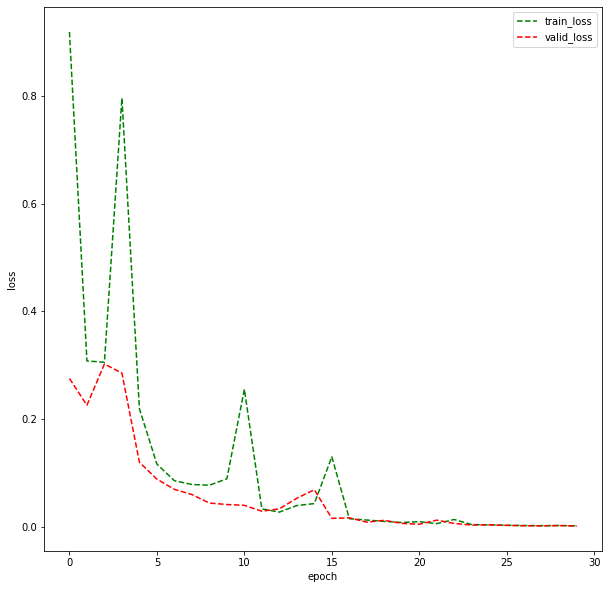

In [101]:
import matplotlib.pyplot as plt  
def plot_epoch_loss(train_loss_list, test_loss_list):
    x_vals = list(range(len(train_loss_list)))
    plt.figure(figsize=(10, 10))
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(x_vals, train_loss_list, 'g--',label='train_loss')
    plt.plot(x_vals, test_loss_list, 'r--',label='valid_loss')
    plt.legend()
    plt.show()

plot_epoch_loss(poly_model.epoch_train_loss[20:], poly_model.epoch_valid_loss[21:])



In [97]:
print(len(poly_model.epoch_train_loss))
print(len(poly_model.epoch_valid_loss))

50
51
